<a href="https://colab.research.google.com/github/TIANBOQIU/AppliedDeepLearning/blob/master/DLfinal_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt-get install -q openslide-tools
!pip install openslide-python

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 11 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (152 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 130812 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os 
from PIL import Image
from skimage.color import rgb2gray

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/My%20Drive', force_remount=True)

In [38]:
!ls '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/slides'

 tumor_001_mask.tif   tumor_031.xml	   tumor_081.tif
 tumor_001.tif	      tumor_035_mask.tif   tumor_081.xml
 tumor_001.xml	      tumor_035.tif	   tumor_084_mask.tif
 tumor_002_mask.tif   tumor_035.xml	   tumor_084.tif
 tumor_002.tif	     'tumor_038 (1).xml'   tumor_084.xml
 tumor_002.xml	      tumor_038.tif	   tumor_091_mask.tif
 tumor_005_mask.tif   tumor_038.xml	   tumor_091.tif
 tumor_005.tif	      tumor_057_mask.tif   tumor_091.xml
 tumor_005.xml	      tumor_057.tif	   tumor_094_mask.tif
 tumor_012_mask.tif   tumor_057.xml	   tumor_094.tif
 tumor_012.tif	      tumor_059_mask.tif   tumor_094.xml
 tumor_012.xml	      tumor_059.tif	   tumor_096_mask.tif
 tumor_016_mask.tif   tumor_059.xml	   tumor_096.tif
 tumor_016.tif	      tumor_064_mask.tif   tumor_096.xml
 tumor_016.xml	      tumor_064.tif	   tumor_099.xml
 tumor_019_mask.tif   tumor_064.xml	   tumor_101_mask.tif
 tumor_019.tif	      tumor_075_mask.tif   tumor_101.tif
 tumor_019.xml	      tumor_075.tif	   tumor_101.xml
 tumor_02

In [5]:
import os, re
path_slides = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/slides'
slides = list(filter(lambda filename: re.match("tumor_[0-9]*\.tif", filename), os.listdir(path_slides)))
masks = list(filter(lambda filename: re.match("tumor_[0-9]*_mask\.tif", filename), os.listdir(path_slides)))
slides = sorted(slides)
masks =sorted(masks)
# tumor_038_mask.tif is missing
slides.remove('tumor_038.tif')
print("total slides {} total masks {}".format(len(slides), len(masks)))
["{} || {}".format(slide, mask) for slide, mask in zip(slides, masks)]


total slides 21 total masks 21


['tumor_001.tif || tumor_001_mask.tif',
 'tumor_002.tif || tumor_002_mask.tif',
 'tumor_005.tif || tumor_005_mask.tif',
 'tumor_012.tif || tumor_012_mask.tif',
 'tumor_016.tif || tumor_016_mask.tif',
 'tumor_019.tif || tumor_019_mask.tif',
 'tumor_023.tif || tumor_023_mask.tif',
 'tumor_031.tif || tumor_031_mask.tif',
 'tumor_035.tif || tumor_035_mask.tif',
 'tumor_057.tif || tumor_057_mask.tif',
 'tumor_059.tif || tumor_059_mask.tif',
 'tumor_064.tif || tumor_064_mask.tif',
 'tumor_075.tif || tumor_075_mask.tif',
 'tumor_078.tif || tumor_078_mask.tif',
 'tumor_081.tif || tumor_081_mask.tif',
 'tumor_084.tif || tumor_084_mask.tif',
 'tumor_091.tif || tumor_091_mask.tif',
 'tumor_094.tif || tumor_094_mask.tif',
 'tumor_096.tif || tumor_096_mask.tif',
 'tumor_101.tif || tumor_101_mask.tif',
 'tumor_110.tif || tumor_110_mask.tif']

We only use tumor_091 to train the previous model and then test on tumot_110

In [0]:
# slide paths and masks path
slide_paths = [os.path.join(path_slides, slide) for slide in slides]
mask_paths = [os.path.join(path_slides, mask) for mask in masks]

2.1. The goal is to train a model on five images and test it on tumor_110.tif (the same as the previous model)

In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def deep_scan(slide, mask, x, y, s, m, width=50, height=50, lv=0):
  if not slide or not mask:
    print('feed in slide and mask object(openslide object)\n')
    return
  ALL_LEVEL = 8
  mapping_factor = 128 # mapping (x, y) to the (X, Y) at level 0
  patch = None
  print('slide width (x-axis) {}  || depth (y-axis) {} || channel {}'.format(s.shape[1], s.shape[0], s.shape[2])) # if you use np.shape, remember to swap
  print('mask  width (x-axis) {}  || depth (y-axis) {} ||'.format(m.shape[1], m.shape[0]))
  print('deep scan at coordinate: ({:<5} (x-axis), {:<5} (y-aixs))\n'.format(x, y))
  
  # s and m are already np array, not the open-slide object
  if m[y][x]:
    print('this pixel is marked as tumor', '[positive]')
  else:
    print('this pixel is not marked as tumor', '[negative]')
   
  # scan all levels for a (width * height) image
  for i in range(0, ALL_LEVEL):
    plt.subplot(2, 4, i + 1)
    region = read_slide(slide, x=x * mapping_factor, y=y * mapping_factor, level=i, width=width, height=height)
    if i == lv: path = region
    plt.imshow(region)
  
  return patch
  
def get_patch(slide, mask, x, y, width=50, height=50, lv=0):
  if not slide or not mask:
    print('feed in slide and mask object(openslide object)\n')
    return
  ALL_LEVEL = 8
  mapping_factor = 128 # mapping (x, y) to the (X, Y) at level 0
  patch = read_slide(slide, x=x * mapping_factor, y=y * mapping_factor, level=lv, width=width, height=height)
  return patch

def find_tumor_pixels(m):
  return [(j, i) for i, row in enumerate(m)
              for j, c in enumerate(row) if c]

# s: the tumor image at some level
# intensity: threshold to filter the image
def find_tissue_pixels(s, intensity=0.8):
  s_gray = rgb2gray(s)
  idx = np.where(s_gray <= intensity)
  return zip(idx[1], idx[0])


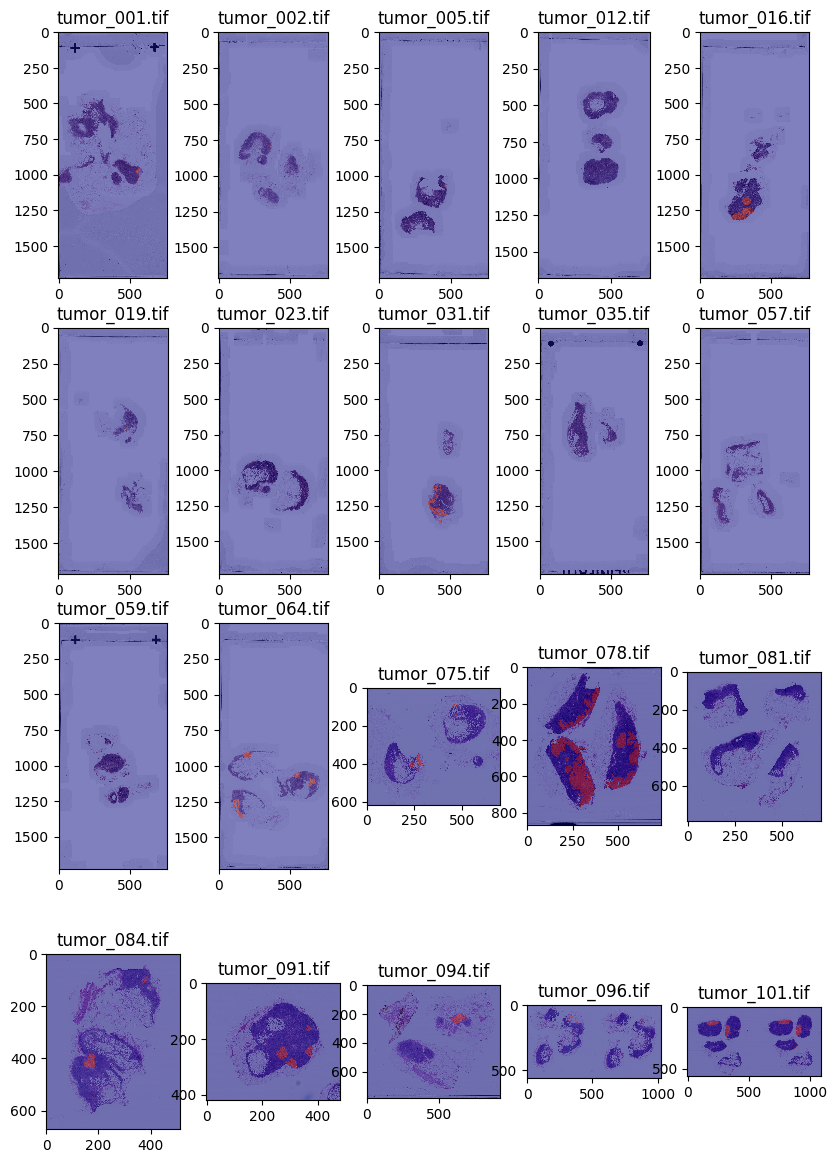

In [8]:
plt.figure(figsize=(10, 15), dpi=100)
for i in range(20):
  slide_path, mask_path = slide_paths[i], mask_paths[i]
  slide, mask = open_slide(slide_path), open_slide(mask_path)
  s = read_slide(slide, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])
  m = read_slide(mask, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])[:,:,0]
  plt.subplot(4, 5, i + 1)
  plt.imshow(s)
  plt.imshow(m, cmap='jet', alpha=0.5)
  plt.title(slide_path.split('/')[-1])

Text(0.5, 1.0, 'tumor_110.tif')

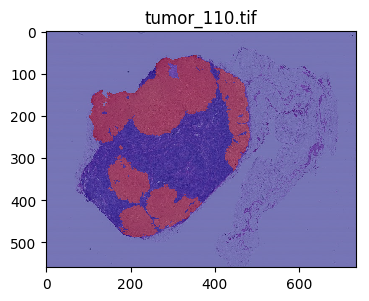

In [10]:
# the previous test image
plt.figure(figsize=(4, 4), dpi=100)
slide_path, mask_path = slide_paths[-1], mask_paths[-1]
slide, mask = open_slide(slide_path), open_slide(mask_path)
s = read_slide(slide, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])
m = read_slide(mask, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])[:,:,0]

plt.imshow(s)
plt.imshow(m, cmap='jet', alpha=0.5)
plt.title(slide_path.split('/')[-1])
# could be better if it is added to the traning set

2.3. choose the training slides

In [0]:
slides_train = ['tumor_078.tif', 'tumor_084.tif', 'tumor_091.tif', 'tumor_110.tif']
masks_train = ['tumor_078_mask.tif', 'tumor_084_mask.tif', 'tumor_091_mask.tif', 'tumor_110_mask.tif']
train_images = []
train_labels = []

slide width (x-axis) 736  || depth (y-axis) 560 || channel 3
mask  width (x-axis) 736  || depth (y-axis) 560 ||
deep scan at coordinate: (304   (x-axis), 295   (y-aixs))

this pixel is not marked as tumor [negative]


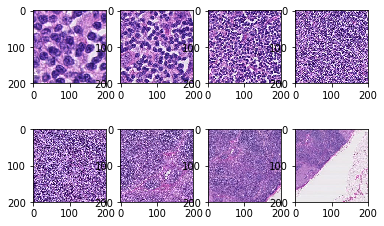

In [12]:
deep_scan(slide, mask, 304, 295, s, m, 200, 200)

2.4 Still working on level 4, maybe we could try some other level later

(299, 299, 3)


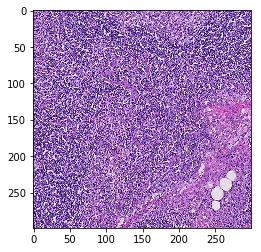

In [13]:
# get patch level = 4
patch = get_patch(slide, mask, 304, 295, 299, 299, 4)
print(patch.shape)
plt.imshow(patch)

In [0]:
## save and read images
#from PIL import Image
#img = Image.fromarray(patch, 'RGB')
#img.save('out.png')

In [0]:
#!ls

In [0]:
#(plt.imread('out.png','RGB') == patch).any()

In [0]:
#print((plt.imread('test_patch.png', 'RGB')[:,:,:3] == patch).any())

In [14]:
# check the training set
for slide_path, mask_path in zip(slides_train, masks_train):
  slide_path = os.path.join(path_slides, slide_path)
  mask_path = os.path.join(path_slides, mask_path)
  slide, mask = open_slide(slide_path), open_slide(mask_path)
  s = read_slide(slide, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])
  m = read_slide(mask, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])[:,:,0]
  loc_tissue = list(find_tissue_pixels(s, 0.8))
  loc_tumor = find_tumor_pixels(m)
  print('{:20} || tissue {:10}  ||  tumor {:10} ({:2f}%)'.format(slide_path.split('/')[-1], len(loc_tissue), len(loc_tumor), 100 * len(loc_tumor)/len(loc_tissue)))



tumor_078.tif        || tissue     215836  ||  tumor      59291 (27.470394%)
tumor_084.tif        || tissue      86562  ||  tumor       1994 (2.303551%)
tumor_091.tif        || tissue      62589  ||  tumor       2924 (4.671747%)
tumor_110.tif        || tissue     137357  ||  tumor      64266 (46.787568%)


In [15]:
# curious about the full list
for slide_path, mask_path in zip(slide_paths, mask_paths):
  slide_path = os.path.join(path_slides, slide_path)
  mask_path = os.path.join(path_slides, mask_path)
  slide, mask = open_slide(slide_path), open_slide(mask_path)
  s = read_slide(slide, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])
  m = read_slide(mask, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])[:,:,0]
  loc_tissue = list(find_tissue_pixels(s, 0.8))
  loc_tumor = find_tumor_pixels(m)
  print('{:20} || tissue {:10}  ||  tumor {:10} ({:2f}%)'.format(slide_path.split('/')[-1], len(loc_tissue), len(loc_tumor), 100 * len(loc_tumor)/len(loc_tissue)))



tumor_001.tif        || tissue     125501  ||  tumor        697 (0.555374%)
tumor_002.tif        || tissue      58873  ||  tumor         61 (0.103613%)
tumor_005.tif        || tissue      59938  ||  tumor        147 (0.245253%)
tumor_012.tif        || tissue      84215  ||  tumor         72 (0.085495%)
tumor_016.tif        || tissue      71958  ||  tumor       9811 (13.634342%)
tumor_019.tif        || tissue      41121  ||  tumor        204 (0.496097%)
tumor_023.tif        || tissue      66186  ||  tumor        120 (0.181307%)
tumor_031.tif        || tissue      46986  ||  tumor       7602 (16.179287%)
tumor_035.tif        || tissue      61831  ||  tumor         12 (0.019408%)
tumor_057.tif        || tissue      55428  ||  tumor         76 (0.137115%)
tumor_059.tif        || tissue      60777  ||  tumor         16 (0.026326%)
tumor_064.tif        || tissue      65796  ||  tumor       8159 (12.400450%)
tumor_075.tif        || tissue      62713  ||  tumor       2944 (4.694401%)
tumor_078

we may use tumor_064.tif to test our model

In [0]:
os.mkdir('data')
os.mkdir('data/tumor')
os.mkdir('data/normal')

In [17]:
!ls data # later we can use generator and data augmentaion

normal	tumor


In [0]:
#!rm -rf data

In [18]:
# slides_train masks_train -> train_images train_labels (balanced)
import random
def get_data(slides_train, masks_train):
  for slide_path, mask_path in zip(slides_train, masks_train):
    slide_path = os.path.join(path_slides, slide_path)
    mask_path = os.path.join(path_slides, mask_path)
    slide, mask = open_slide(slide_path), open_slide(mask_path)
    s = read_slide(slide, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])
    m = read_slide(mask, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])[:,:,0]
    loc_tissue = list(find_tissue_pixels(s, 0.8))
    loc_tumor = find_tumor_pixels(m)
    
    loc_tissue = set(loc_tissue)
    loc_tumor = set(loc_tumor)
    loc_normal = loc_tissue - loc_tumor
    for i, loc in enumerate(loc_tumor):
      patch = get_patch(slide, mask, *loc, 299, 299, 4) # train on level 4
      img = Image.fromarray(patch, 'RGB')
      img.save('data/tumor/{}_{}_{}.png'.format(slide_path.split('/')[-1][:-4], *loc))
      if i%100 == 0: print('saving tumor patches {:<2f}%'.format(100 * (i+1)/len(loc_tumor), slide_path.split('/')[-1]))
      
    # balance
    normal = list(loc_normal)
    random.shuffle(normal)
    for i, loc in enumerate(normal[:len(loc_tumor)]):
      patch = get_patch(slide, mask, *loc, 299, 299, 4)
      img = Image.fromarray(patch, 'RGB')
      img.save('data/normal/{}_{}_{}.png'.format(slide_path.split('/')[-1][:-4], *loc))
      if i%100 == 0: print('saving normal patches {:<2f}% || {:10}'.format(100 * (i+1)/len(loc_normal), slide_path.split('/')[-1]))
    
get_data(slides_train, masks_train)

saving tumor patches 0.001687%
saving tumor patches 0.170346%
saving tumor patches 0.339006%
saving tumor patches 0.507666%
saving tumor patches 0.676325%
saving tumor patches 0.844985%
saving tumor patches 1.013645%
saving tumor patches 1.182304%
saving tumor patches 1.350964%
saving tumor patches 1.519624%
saving tumor patches 1.688283%
saving tumor patches 1.856943%
saving tumor patches 2.025603%
saving tumor patches 2.194262%
saving tumor patches 2.362922%
saving tumor patches 2.531582%
saving tumor patches 2.700241%
saving tumor patches 2.868901%
saving tumor patches 3.037561%
saving tumor patches 3.206220%
saving tumor patches 3.374880%
saving tumor patches 3.543539%
saving tumor patches 3.712199%
saving tumor patches 3.880859%
saving tumor patches 4.049518%
saving tumor patches 4.218178%
saving tumor patches 4.386838%
saving tumor patches 4.555497%
saving tumor patches 4.724157%
saving tumor patches 4.892817%
saving tumor patches 5.061476%
saving tumor patches 5.230136%
saving t

In [0]:
# ! cp -R 'data' '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/data'

In [36]:
# ! cp -r 'data/normal' '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/data/normal'
# check below

^C


In [45]:
# !ls '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/data/normal'
# strange.. the data/normal didn't show in my drive, async issue? wait for a while.
# ok.. even data/tumor is not synced, just wait it's still working

normal		       tumor_078_49_476.png   tumor_110_274_280.png
tumor_078_0_11.png     tumor_078_494_794.png  tumor_110_274_281.png
tumor_078_0_1.png      tumor_078_494_821.png  tumor_110_274_282.png
tumor_078_0_2.png      tumor_078_494_822.png  tumor_110_274_283.png
tumor_078_0_835.png    tumor_078_49_484.png   tumor_110_274_284.png
tumor_078_0_840.png    tumor_078_494_854.png  tumor_110_274_285.png
tumor_078_0_845.png    tumor_078_494_855.png  tumor_110_274_286.png
tumor_078_0_9.png      tumor_078_494_857.png  tumor_110_274_287.png
tumor_078_100_10.png   tumor_078_494_859.png  tumor_110_274_289.png
tumor_078_100_181.png  tumor_078_494_8.png    tumor_110_274_290.png
tumor_078_100_217.png  tumor_078_494_91.png   tumor_110_274_291.png
tumor_078_100_225.png  tumor_078_494_94.png   tumor_110_274_292.png
tumor_078_100_238.png  tumor_078_494_9.png    tumor_110_274_293.png
tumor_078_100_242.png  tumor_078_49_510.png   tumor_110_274_294.png
tumor_078_100_245.png  tumor_078_495_110.png  tumor_110_

In [8]:
_path = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/data/tumor'
print(len(os.listdir(_path)))
#print(len(os.listdir('data/tumor')))
#print(len(os.listdir('data/normal')))
#print(os.listdir('data/normal')[:20])

OSError: ignored

2.  after the dataset is uploaded into the drive, I will start building transfer learning, and use generator to save some space

2.1. but if it is too slow, I may use just a part of data for the traning (or the feature can't fit into the memory)

2.2 since we have the patches in storage, we can evaluate the accuracy (could be a patch level metric)